In [9]:
import scanpy as sc
import anndata as ad
from scprocessing.Pipeline import Pipeline
from scprocessing.QC import QC
from scprocessing.Normalization import Normalization
from scprocessing.Integration import Integration
from scprocessing.metrics import jaccard, silhouette, davies, calinski, evaluate
from scprocessing.SelectPipeline import SelectPipeline
import numpy as np
import pandas as pd
from typing import List
from anndata import AnnData

In [3]:
%load_ext autoreload
%autoreload 2

# Reading Datasets

In [4]:
immune = sc.read_h5ad("/mnt/shared/nationwide/cell_type_datasets/human_brca_immune.h5ad")
immune.var_names_make_unique()
immune.obs_names_make_unique()
immune.obs["Type"] = "Immune"
immune.obs["Type"] = immune.obs["Type"].astype("category")
del immune.obsm["X_diffmap"]

In [5]:
def splitAD(dataset: AnnData, key: str) -> List[AnnData]:
    """
    Parameters:
        dataset: AnnData object
        key: observation field to split the dataset into
    Return:
        List of anndata split by key
    """
    unique_values = dataset.obs[key].unique()
    subsets = []
    
    # Iterate over unique values and create subsets
    for value in unique_values:
        subsets.append(dataset[dataset.obs[key] == value].copy())
    return subsets

# Model Selection

In [6]:
immune_data = splitAD(immune, "tissue_condition")[:5]
select_immune = SelectPipeline(normalization=["seurat", "zheng17"],\
                                  integration=["harmony", "scanorama"],\
                                  metrics=["jaccard", "ari", "nmi"],
                                  resolution_range=[0.3],
                               key="tissue_condition"
                                 )

Normalizing Datasets
Integrating Datasets


2024-06-03 21:19:06,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-03 21:19:08,753 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-03 21:19:08,828 - harmonypy - INFO - Iteration 1 of 10
2024-06-03 21:19:12,302 - harmonypy - INFO - Iteration 2 of 10
2024-06-03 21:19:15,833 - harmonypy - INFO - Iteration 3 of 10
2024-06-03 21:19:17,556 - harmonypy - INFO - Iteration 4 of 10
2024-06-03 21:19:18,787 - harmonypy - INFO - Iteration 5 of 10
2024-06-03 21:19:20,000 - harmonypy - INFO - Iteration 6 of 10
2024-06-03 21:19:21,271 - harmonypy - INFO - Converged after 6 iterations
/home/user/Workspace/scRNAseq-benchmarking/scprocessing/Integration.py:58: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(
/home/user/.conda/envs/scelec

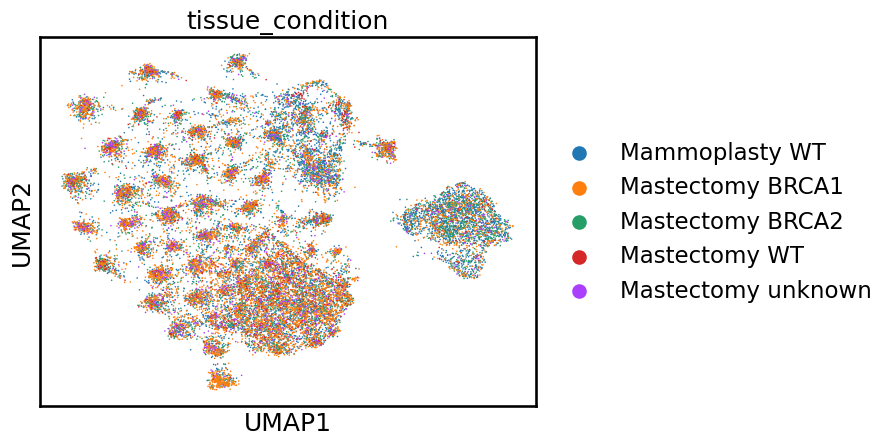

Integrating Datasets


/home/user/Workspace/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:84: UserWarning: Error occured while using seurat normalization and scanorama integration: 
please install Scanorama:

	pip install scanorama
  warnings.warn(
/home/user/Workspace/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:87: UserWarning: Skipping seurat normalization and scanorama integration
  warnings.warn(


Normalizing Datasets
Integrating Datasets


2024-06-03 21:20:14,683 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-03 21:20:17,386 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-03 21:20:17,452 - harmonypy - INFO - Iteration 1 of 10
2024-06-03 21:20:21,543 - harmonypy - INFO - Iteration 2 of 10
2024-06-03 21:20:25,753 - harmonypy - INFO - Iteration 3 of 10
2024-06-03 21:20:29,704 - harmonypy - INFO - Iteration 4 of 10
2024-06-03 21:20:34,005 - harmonypy - INFO - Iteration 5 of 10
2024-06-03 21:20:35,650 - harmonypy - INFO - Iteration 6 of 10
2024-06-03 21:20:37,314 - harmonypy - INFO - Converged after 6 iterations


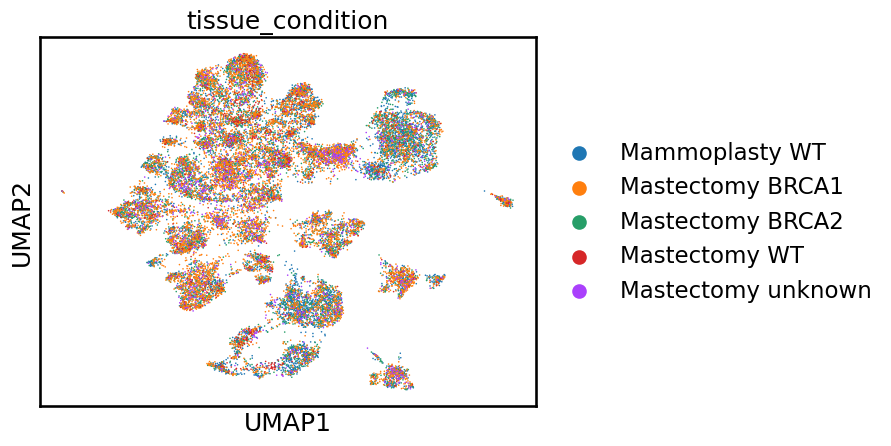

Integrating Datasets


/home/user/Workspace/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:84: UserWarning: Error occured while using zheng17 normalization and scanorama integration: 
please install Scanorama:

	pip install scanorama
  warnings.warn(
/home/user/Workspace/scRNAseq-benchmarking/scprocessing/SelectPipeline.py:87: UserWarning: Skipping zheng17 normalization and scanorama integration
  warnings.warn(


In [7]:
immune_res, report_immune, pipeline_immune = select_immune.search(immune_data, key_metric="ari")

In [10]:
final_df = []
for key, cluster in select_immune.clusters.items():
    init_df = pd.DataFrame(cluster.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
    init_df["tissue_condition"] = cluster.obs.tissue_condition.tolist()
    init_df["Normalization"] = key[0]
    init_df["Integration"] = key[1]
    final_df.append(init_df)
final_df = pd.concat(final_df)

In [12]:
# this cell just filters the final_df
filtered_df = final_df[final_df["Integration"] != "merge"]
all_cells = []
for condition in filtered_df["tissue_condition"].unique():
    all_cells.append(filtered_df[filtered_df["tissue_condition"] == condition])
filtered_df = pd.concat(all_cells)
filtered_df

,UMAP1,UMAP2,tissue_condition,Normalization,Integration
0,-4.559619,5.575281,Mammoplasty WT,seurat,harmony
1,10.015896,2.023539,Mammoplasty WT,seurat,harmony
2,-2.300254,-2.563284,Mammoplasty WT,seurat,harmony
3,1.182357,-5.764402,Mammoplasty WT,seurat,harmony
4,4.019958,-2.105201,Mammoplasty WT,seurat,harmony
...,...,...,...,...,...
23041,-3.233245,9.530375,Mastectomy unknown,zheng17,harmony
23042,-5.255260,6.163692,Mastectomy unknown,zheng17,harmony
23043,-2.767376,7.168053,Mastectomy unknown,zheng17,harmony
23044,3.597882,6.783140,Mastectomy unknown,zheng17,harmony


In [13]:
import altair as alt
import pandas as pd
alt.data_transformers.enable("vegafusion")

high_contrast_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

umap_chart = alt.Chart(filtered_df).mark_point(size=1.5).encode(
    x="UMAP1",
    y="UMAP2",
    color=alt.Color("tissue_condition").scale(range=high_contrast_colors)
)

facet_grid = umap_chart.facet(
    row="Normalization",
    column="Integration",
    title='UMAP plots for Different Combinations of Normalization and Integration Methods'
)
facet_grid = facet_grid.configure_axis(
    grid=False,
    labelFontSize=18,
    titleFontSize=18,
    tickSize=2
)

facet_grid = facet_grid.configure_header(
    labelFontSize=18,
    titleFontSize=18
)

facet_grid = facet_grid.configure_headerRow(
    labelFontSize=18,
    titleFontSize=18
)

facet_grid = facet_grid.configure_headerColumn(
    labelFontSize=18,
    titleFontSize=18
)

facet_grid = facet_grid.configure_legend(
    titleFontSize=18,
    labelFontSize=16
)

facet_grid.save("hbca.png", scale_factor=5.0)